# One-Dimensional Kalman Filter - Dynamic Systems
We here take into consideration a free falling object. A tracking radar is placed on ground and measures the height of the object during the fall. The state is represented as the position along the vertical direction:

### $$ x(t)=x_{0} - v_{0}* t - \frac{1}{2}*g*t^{2}  $$

In the following code a measurements set is calculated. The user can set the measurements update rate and the 1-sigma uncertainty of the radar. The initial height is also a parameter. The initial speed $ v_{0} $ is assumed to be zero.

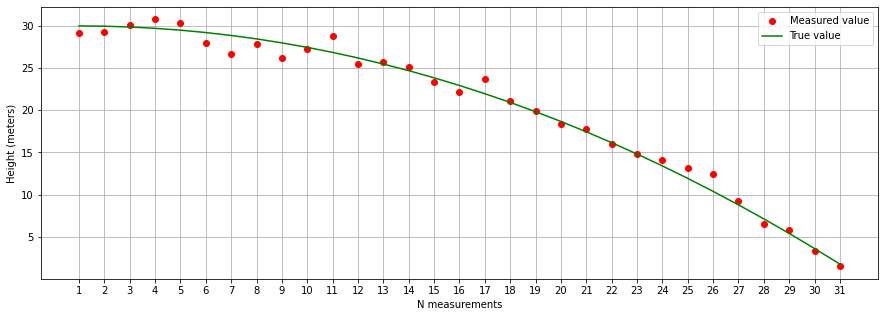

In [3]:
import numpy as np
import math
import matplotlib.pyplot as plt
%matplotlib inline

############## input data ################
trueInitialPosition = 30 # meters

##### radar performances
deltaT = 0.08 # sec - interval between measurements 
measUncertainty = 1 # meters - 1-sigma uncertainty of the measuring device

#########################################

##### model the dynamics to get the "true" data
truePositions = []
truePositions.append(trueInitialPosition)

trueCurrentPosition = trueInitialPosition
index = 1
while (trueCurrentPosition > 0):
 currentTime = index * deltaT
 trueCurrentPosition = trueInitialPosition - 0.5 * 9.81 * math.pow(currentTime, 2)
 if trueCurrentPosition > 0:
  truePositions.append(trueCurrentPosition)
  index += 1

#### emulate the measurements
measurements = truePositions + measUncertainty * np.random.randn(index)

plt.plot(np.arange(1, index+1, 1.0), measurements, 'ro', label='Measured value')
plt.plot(np.arange(1, index+1, 1.0), truePositions, color='green', label='True value')
plt.xlabel('N measurements')
plt.ylabel('Height (meters)')
plt.xticks(np.arange(1, index+1, 1.0))
plt.grid(True)
leg = plt.legend()
fig = plt.gcf()
fig.set_size_inches(15,5)

## Kalman filter implementation

### The dynamic model equations (prediction)
The way in which the system evolves over time is modeled by using a couple of equations, one describing the state evolution over time and the other one quantifying the relevant uncertainty. For the system under consideration the state evolution equations are:

### \begin{split} 
{\hat{x}_{n,n-1}} &= {\hat{x}_{n-1,n-1}} + {\hat{v}_{n-1,n-1} * \Delta t} \\ 
{\hat{v}_{n,n-1}} &= {\hat{v}_{n-1,n-1} - g * \Delta t} 
\end{split}

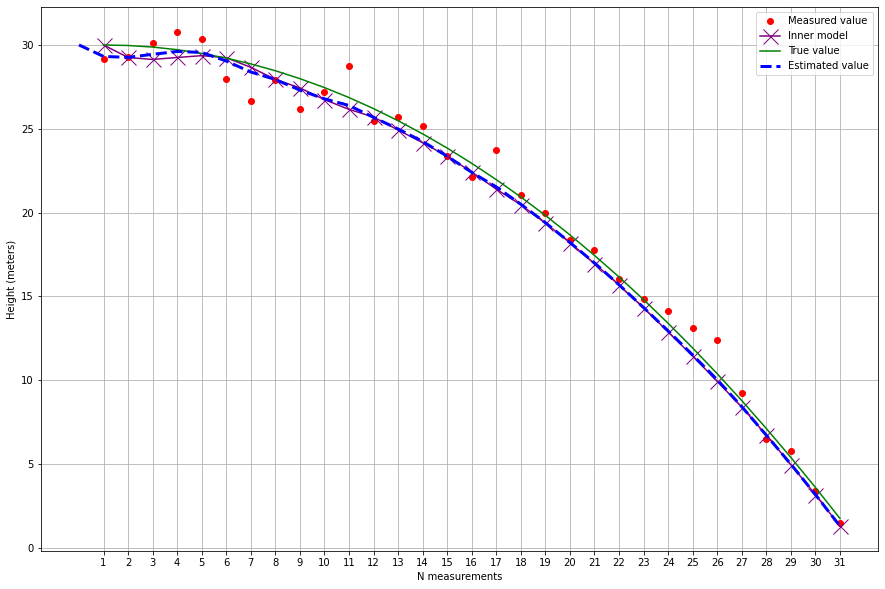

In [4]:

##### initial estimates
initialPositionEstimation = 30 # meters
initialPositionUncertainty = 2 # meters - 1-sigma uncertainty of the state estimate

####### initialization 
positionEstimates = []
positionEstimates.append(initialPositionEstimation)

positionUncertainties = []
positionUncertainties.append(initialPositionUncertainty)

kalmanGains = []

p = initialPositionUncertainty * initialPositionUncertainty # initial variance for the state
r = measUncertainty * measUncertainty # variance of the measuring device
estimatedPosition = initialPositionEstimation
estimatedVelocity = 0

innerModel = []

for y in measurements:
    
    ### predict ###
    estimatedPosition = estimatedPosition + estimatedVelocity * deltaT
    estimatedVelocity = estimatedVelocity - 9.81 * deltaT
    innerModel.append(estimatedPosition)

    ### update ###
    kalmanGain = p / (p + r)
    estimatedPosition = estimatedPosition + kalmanGain * (y - estimatedPosition)
    p = (1-kalmanGain) * p
    
    positionEstimates.append(estimatedPosition)
    kalmanGains.append(kalmanGain)
    positionUncertainties.append(math.sqrt(p))
    
plt.plot(np.arange(1, index+1, 1.0), measurements, 'ro', label='Measured value')
plt.plot(np.arange(1, index+1, 1.0), innerModel, color='purple', marker='x', label='Inner model', markersize='15')
plt.plot(np.arange(1, index+1, 1.0), truePositions, color='green', label='True value')
plt.plot(np.arange(0, index+1, 1.0), positionEstimates, color='blue', linewidth=3, label='Estimated value', linestyle='--')

plt.xlabel('N measurements')
plt.ylabel('Height (meters)')
plt.xticks(np.arange(1, index+1, 1.0))
plt.grid(True)
leg = plt.legend()
fig = plt.gcf()
fig.set_size_inches(15,10)

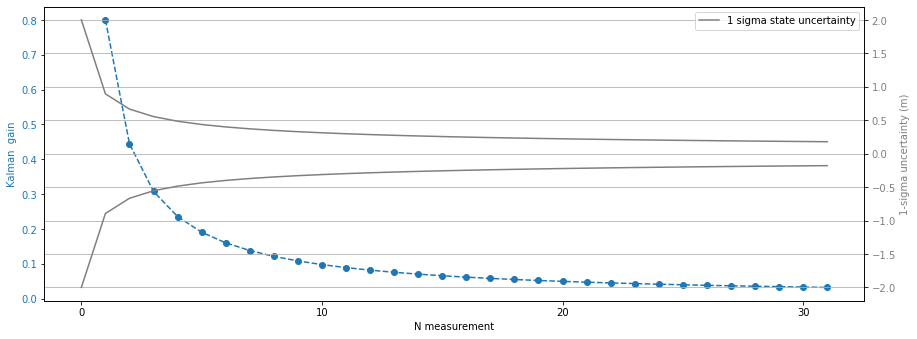

In [5]:
fig, ax1 = plt.subplots()

color = 'tab:blue'
ax1.set_xlabel('N measurement')
ax1.set_ylabel('Kalman  gain', color=color)
ax1.plot(np.arange(1, index+1, 1.0), kalmanGains, '--o', color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:gray'
ax2.set_ylabel('1-sigma uncertainty (m)', color=color)  # we already handled the x-label with ax1
ax2.plot(np.arange(0, index+1, 1.0), np.array(positionUncertainties), color=color, label = '1 sigma state uncertainty')
ax2.plot(np.arange(0, index+1, 1.0), -np.array(positionUncertainties), color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
fig.set_size_inches(15,5)
plt.xticks(np.arange(0, index+1, 10))
plt.grid(True)
leg = plt.legend()
plt.show()

An high Kalman gain (close to 1) means that the measure uncertainty is smaller than the overall state estimate uncertainty. Here the filter gives an higher importance to the measurements than the predicted value from the model. When the Kalman Gain is low (close to 0), the measurements have a small weight and the filter gives more importance to the estimated values from the model.
If the measurement uncertainty is equal to the estimate uncertainty, then the Kalman gain equals to 0.5.